$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$


# Reinforcement Learning with Neural Network Function Approximation



So far, we have learned about the reinforcement learning and how we can implement temporal difference learning with tabular function approximation. 
Here, we observed that the table cannot hold all the information when the number of states or actions is very large. 
Not only for the memory, but the time to take until it fills out the cells correctly can matter.
We refer this issue as *generalization*. 
The question that we will discuss is how to generalize to produce a good estimation over unexperienced state space based on the experience from the limited set of the state space.

This kind of generalization is called as *function approximation*. 
For this, we do not reinvent wheels for reinforcement learning. Lots of study in supervised learning already suggested various techniques including artificial neural networks, which we have learned last week. 



## Example problem in continuous state space



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd  # for display and clear_output
import collections
from copy import deepcopy as copy

from util import Standardizer

In [2]:
class Marble():
    """ 1d marble problem
        
        states: x, dx
        action: action [-1,1]


        |            ___                     |
        |___________|///|____G_______________|
                    <- ->
    """

    def __init__(self,goal=5, **params):
        # len(state) + action (1)
        self.n_state = 2
        self.n_action = 1
        self.Goal = goal
        self.bound = params.pop('bound', [0, 10, -5, 5])
        if len(self.bound) != 4:
             self.bound = self.bound[:2] + [-5, 5]

        self._st_range = np.array([self.bound[:2], self.bound[2:], [-1, 1]]).T
        self.nnNI = self.n_state + 1
        self.goal_width = 1
        
        self._s = [0, 0]

    def init(self, start=None):
        if start is not None:
            self._s = start
        else: 
            self._s = [np.random.randint(self.bound[0], self.bound[1]), 0.]
        return self._s
       
    def get_random_action(self):
        return float(np.random.randint(3) -1) # discrete action

    def get_bound_act(self, a):
        if a[0] > 1:
            return 1
        elif a[0] < -1:
            return -1
        else:
            return a[0]

    def next(self, a) :
        s = self._s
        if isinstance(a, collections.Iterable):
            a = a[0]
        s1 = copy(s)
        dT = 0.1
        s1[0] += dT * s[1]  
        s1[1] += dT * ( 2*a - 0.2 * s[1] )

        # adjust velocity when outside of the track
        if s1[0] < self.bound[0]:
            s1[:]  = [self.bound[0], 0]
        elif s1[0] > self.bound[1] :
            s1[:] = [self.bound[1], 0]
        # clipping the velocity
        s1[1] = np.clip(s1[1], self._st_range[0, 1],
                               self._st_range[1, 1])

        self._s =  s1
        return self.get_reward(s, s1, a)

    def get_cur_state(self):
        return self._s

    def get_reward(self,s,s1,a):
        return 1 if abs(s1[0] - self.Goal) < self.goal_width else 0

    def get_state_range(self):
        return self._st_range

    def get_actions(self):
        return np.array([-1., 0., 1.])

    def get_action_index(self, action):
        return np.where(np.array([-1, 0, 1]) == action)[0][0]

    def draw_trajectory(self, smplX):
        if smplX.shape[1] == 1: return
        plt.plot(smplX[:,0],smplX[:,1])
        plt.axis([self.bound[0], self.bound[1],-5,5])
        plt.plot(smplX[0,0],smplX[0,1],'go')
        plt.plot(self.Goal,0,'ro')
        # draw a goal region
        plt.fill_between([self.Goal-self.goal_width, self.Goal+self.goal_width],
                         [-5,-5], [5,5],
                         color="red", alpha=0.3)
        plt.xlabel("s") 
        plt.ylabel("s dot")


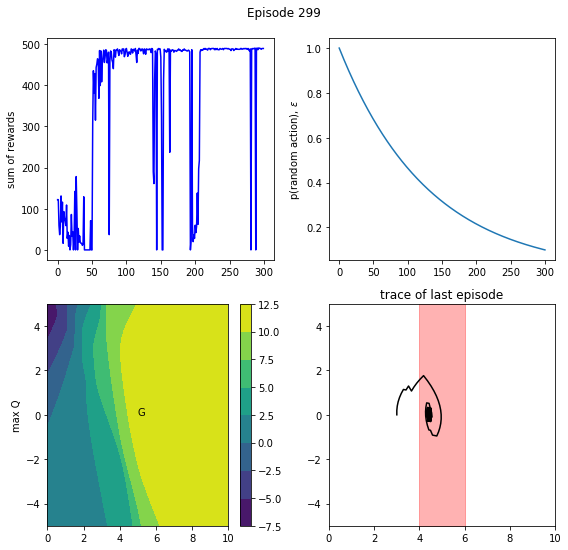

In [15]:
## Parameters
K = 300 
n_actions = 3 
max_steps = 500
gamma = 0.9
verbose = False

epsilon = 1.
final_epsilon = 0.1
epsilon_decay =  np.exp(np.log(final_epsilon) / K)

####################
nHiddens = 5
nSamples = 1
nOutputs = 1
nInputs = 3
max_iter = 10

rhoh = rhoo = 0.01

rh = rhoh / (nSamples*nOutputs)
ro = rhoo / (nSamples*nOutputs)

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(nInputs+1,nHiddens))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+nHiddens,nOutputs))-0.5)

# Add constant column of 1's
def addOnes(A):
    return np.insert(A, 0, 1, axis=len(np.array(A).shape)-1)

def forward(X):
    X = stdX.standardize(X)
    # Forward pass on training data
    X1 = addOnes(X)
    Z = np.tanh(X1 @ V)
    Z1 = addOnes(Z)
    Y = Z1 @ W
    return Y, Z

def as_array(A):
    A = np.array(A)
    if len(A.shape) == 1:
        return A.reshape((1, -1))
    return A

def backward(error, Z, X):
    
    ### make sure the array shapes
    X = as_array(X)
    Z = as_array(Z)
    E = as_array(error)
    
    Z1 = addOnes(Z)
    X1 = addOnes(X)

    # Backward pass - the backpropagation and weight update steps
    dV = rh * X1.T @ ( ( E @ W[1:,:].T) * (1-Z**2))
    dW = ro * Z1.T @ E
    return dV, dW


def epsilon_greedy(e, s):
    if np.random.rand() < e:
        return np.random.randint(n_actions) - 1
    else:
        Q, _ = forward(np.hstack((np.tile(s, (3,1)), env.get_actions().reshape((-1, 1)))))
        max_as = np.where(Q == np.max(Q))[0] - 1 # index to action value
        return np.random.choice(max_as)
        

fig = plt.figure(figsize=(8, 8))
####################
# Cart model environment 
env = Marble()

####################
# Normalize 
stdX = Standardizer(env.get_state_range())


# rewards and step trace
rtrace = []
etrace = [epsilon]
for j in range(K):

    if verbose: print("\tepisode #", j, "   ",end="")
    env.init([3,0]) #[float(np.random.randint(-5, 5, 1)), 0])
    s = env.get_cur_state()
    # selection an action
    a = epsilon_greedy(epsilon, s)

    rewards = []
    trace = np.array(s)
    for step in range(max_steps):
        if verbose: print("\tstep #", step, "   ",end="")
        # move
        r1 = env.next(a)
        s1 = env.get_cur_state()
        a1 = epsilon_greedy(epsilon, s1)

        rewards.append(r1)
        trace = np.vstack((trace, s1))

        # update neural networks
        Q1, _ = forward(np.hstack((s1, a1)))  # output of neural network is Q for next state
        Q, Z = forward(np.hstack((s, a)))  # output of neural network is Q for next state
        error = r1 + gamma * Q1 - Q  # use action value as index by adding one
        dV, dW = backward(error, Z, np.hstack((s, a)))
        V += dV
        W += dW

        s = s1
        a = a1
        
    epsilon *= epsilon_decay
    etrace.append(epsilon)


    if verbose: print("Done (", np.sum(rewards), ")", step)

    rtrace.append(np.sum(rewards))

    last_plot = (j == K-1)
    
    if j % 10 == 0 or last_plot:
        plt.clf()
        fig.add_subplot(221)
        plt.plot(rtrace, "b-")
        plt.ylabel("sum of rewards")

        fig.add_subplot(222)
        plt.plot(etrace, "-")
        plt.ylabel("p(random action), $\epsilon$")

        # contour plot for Q
        fig.add_subplot(223)
        xs, ys = np.meshgrid(np.linspace(0, 10, 100), np.linspace(-5, 5, 100))

        X = np.vstack((xs.flat, ys.flat)).T

        Q = np.array([forward(np.hstack((x, a)))[0] for a in [-1, 0, 1] for x in X])

        maxQ = np.max(Q.reshape((3, -1)), axis=0)
        cs = plt.contourf(xs, ys, maxQ.reshape(xs.shape))
        plt.colorbar(cs)
        plt.text(env.Goal, 0, 'G')
        plt.ylabel("max Q")

        # plot traces
        fig.add_subplot(224)
        plt.plot(trace[:, 0], trace[:, 1], "k-")
        plt.fill_between([env.Goal-1, env.Goal+1], [-5, -5],[5, 5], color='red', alpha=0.3)
        plt.title("trace of last episode")
        plt.xlim([0, 10])
        plt.ylim([-5, 5])

        plt.suptitle(''.join(["Episode ",str(j)]))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.draw()

        ipd.clear_output(wait=True)
        ipd.display(fig)
ipd.clear_output(wait=True)

In [16]:
def testIt(nTrials,nStepsPerTrial):
    xs = np.linspace(0,10,nTrials)
    for x in xs:
        s = env.init([x,0]) ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a = epsilon_greedy(0, s) # epsilon = 0
            env.next(a)
            s = env.get_cur_state()
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([5,5],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

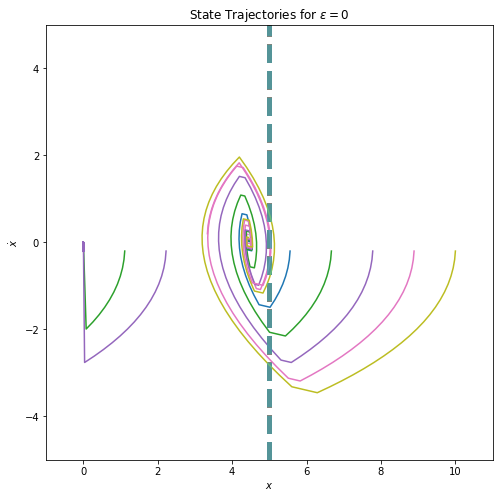

In [17]:
plt.figure(figsize=(8,8))
testIt(10, 100)